## Introduction

Attention is, to some extent, motivated by how we pay visual attention to different regions of an image or correlate words in one sentence.

In a nutshell, attention in the deep learning can be broadly interpreted as a vector of importance weights: in order to predict or infer one element, such as a pixel in an image or a word in a sentence, we estimate using the attention vector how strongly it is correlated with other elements and take the sum of their values weighted by the attention vector as the approximation of the target.

The seq2seq model aims to transform an input sequence (source) to a new one (target) and both sequences can be of arbitrary lengths. Examples of transformation tasks include machine translation between multiple languages in either text or audio, question-answer dialog generation, or even parsing sentences into grammar trees. A critical and apparent disadvantage of it's fixed-length context vector design is incapability of remembering long sentences. Often it has forgotten the first part once it completes processing the whole input. The attention mechanism was born to resolve this problem.

### Applications

1. **Attention in text translation**

Given an input sequence of a sentence in French, translate and output a sentence in English. Attention is used to pay attention to specific words in the input sequence for each word in the output sequence.


2. **Attention in Image Description**

Different from the glimpse approach, the sequence-based attentional mechanism can be applied to computer vision problems to help get an idea of how to best use the convolutional neural network to pay attention to images when outputting a sequence, such as a caption. Given an input of an image, output an English description of the image. Attention is used to pay focus on different parts of the image for each word in the output sequence.

![](https://insidebigdata.com/wp-content/uploads/2018/09/Eleks_6.png)

#### Simple Working Example

Gaussian attention works by exploiting parametrised one-dimensional Gaussian filters to create an image-sized attention map. As you can observe, attention vectors specify which part of the image should be attended to in x and y axis, respectively. The attention masks can be created as follows.

<img src="https://akosiorek.github.io/ml/2017/10/14/hard_gauss.jpeg" style="height: 300px;" />  

The code below lets you create matrix-valued masks for a mini-batch of samples in Tensorflow. If you want to create , you would call it as Ay = gaussian_mask(u, s, d, h, H), where u, s, d are and , in that order and specified in pixels.

In [17]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [18]:
img_size = 10, 10
glimpse_size = 5, 5

x = abs(np.random.randn(1, *img_size)) * .3
x[0, 3:6, 3:6] = 1

# Make a crop
crop = x[0, 2:7, 2:7]

In [19]:
def gaussian_mask(u, s, d, R, C):
    """
    :param u: tf.Tensor, centre of the first Gaussian.
    :param s: tf.Tensor, standard deviation of Gaussians.
    :param d: tf.Tensor, shift between Gaussian centres.
    :param R: int, number of rows in the mask, there is one Gaussian per row.
    :param C: int, number of columns in the mask.
    """
    # indices to create centres
    R = tf.to_float(tf.reshape(tf.range(R), (1, 1, R)))
    C = tf.to_float(tf.reshape(tf.range(C), (1, C, 1)))
    centres = u[np.newaxis, :, np.newaxis] + R * d
    column_centres = C - centres
    mask = tf.exp(-.5 * tf.square(column_centres / s))
    # we add eps for numerical stability
    normalised_mask = mask / (tf.reduce_sum(mask, 1, keep_dims=True) + 1e-8)
    return normalised_mask

def gaussian_glimpse(img_tensor, transform_params, crop_size):
    """
    :param img_tensor: tf.Tensor of size (batch_size, Height, Width, channels)
    :param transform_params: tf.Tensor of size (batch_size, 6), where params are  (mean_y, std_y, d_y, mean_x, std_x, d_x) specified in pixels.
    :param crop_size): tuple of 2 ints, size of the resulting crop
    """
    # parse arguments
    h, w = crop_size
    H, W = img_tensor.shape.as_list()[1:3]
    split_ax = transform_params.shape.ndims -1
    uy, sy, dy, ux, sx, dx = tf.split(transform_params, 6, split_ax)
    # create Gaussian masks, one for each axis
    Ay = gaussian_mask(uy, sy, dy, h, H)
    Ax = gaussian_mask(ux, sx, dx, w, W)
    # extract glimpse
    glimpse = tf.matmul(tf.matmul(Ay, img_tensor, adjoint_a=True), Ax)
    return glimpse

In [20]:
tf.reset_default_graph()

# placeholders
tx = tf.placeholder(tf.float32, x.shape)
tu = tf.placeholder(tf.float32, [1])
ts = tf.placeholder(tf.float32, [1])
td = tf.placeholder(tf.float32, [1])
stn_params = tf.placeholder(tf.float32, [1, 4], 'stn_params')

In [21]:
# Gaussian Attention
gaussian_att_params = tf.concat([tu, ts, td, tu, ts, td], -1)
gaussian_glimpse_expr = gaussian_glimpse(tx, gaussian_att_params, glimpse_size)

In [22]:
sess = tf.Session()

# extract a Gaussian glimpse
u = 2
s = .5
d = 1
u, s, d = (np.asarray([i]) for i in (u, s, d))
gaussian_crop = sess.run(gaussian_glimpse_expr, feed_dict={tx: x, tu: u, ts: s, td: d})

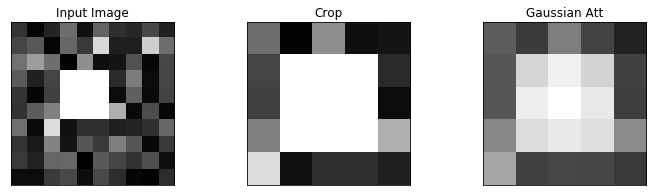

In [23]:
# plots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

titles = ['Input Image', 'Crop', 'Gaussian Att']
imgs = [x, crop, gaussian_crop]
for ax, title, img in zip(axes, titles, imgs):
    ax.imshow(img.squeeze(), cmap='gray', vmin=0., vmax=1.)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

3. **Attention in Entailment**

Given a premise scenario and a hypothesis about the scenario in English, output whether the premise contradicts, is not related, or entails the hypothesis.  
For example:  

premise: “A wedding party taking pictures“  
hypothesis: “Someone got married“  

Attention is used to relate each word in the hypothesis to words in the premise, and vise-versa.

### Self Attention Mechanism
Self-attention, also known as intra-attention, is an attention mechanism relating different positions of a single sequence in order to compute a representation of the same sequence. It has been shown to be very useful in machine reading, abstractive summarization, or image description generation.

## Transformer Model

It is actually possible to do seq2seq modeling without recurrent network units using the transformer models. The proposed “transformer” model is entirely built on the self-attention mechanisms without using sequence-aligned recurrent architecture.

### Key Value and Query

The major component in the transformer is the unit of multi-head self-attention mechanism. The transformer views the encoded representation of the input as a set of key-value pairs, , both of dimension (input sequence length); in the context of NMT, both the keys and values are the encoder hidden states. In the decoder, the previous output is compressed into a query ( of dimension ) and the next output is produced by mapping this query and the set of keys and values.

*The attention weights are the relevance scores of the input encoder hidden states (values), in processing the decoder state (query). This is calculated using the encoder hidden states (keys) and the decoder hidden state (query).*

The transformer adopts the scaled dot-product attention: the output is a weighted sum of the values, where the weight assigned to each value is determined by the dot-product of the query with all the keys.

### Multi-Head Self-Attention

<img src="https://lilianweng.github.io/lil-log/assets/images/multi-head-attention.png" style="height: 350px;" />  

                                    Multi-head scaled dot-product attention mechanism
                                   
Rather than only computing the attention once, the multi-head mechanism runs through the scaled dot-product attention multiple times in parallel. The independent attention outputs are simply concatenated and linearly transformed into the expected dimensions.

### Encoder

<img src="https://lilianweng.github.io/lil-log/assets/images/transformer-encoder.png" style="height: 250px;" />  

                                       The transformer’s encoder

The encoder generates an attention-based representation with capability to locate a specific piece of information from a potentially infinitely-large context.  

1. A stack of N=6 identical layers.
2. Each layer has a multi-head self-attention layer and a simple position-wise fully connected feed-forward network.
3. Each sub-layer adopts a residual connection and a layer normalization. All the sub-layers output data of the same dimension.

### Decoder

<img src="https://lilianweng.github.io/lil-log/assets/images/transformer-decoder.png" style="height: 300px;" />  

                                        The transformer's decoder

The decoder is able to retrieval from the encoded representation.

1. A stack of N = 6 identical layers
2. Each layer has two sub-layers of multi-head attention mechanisms and one sub-layer of fully-connected feed-forward network.
3. Similar to the encoder, each sub-layer adopts a residual connection and a layer normalization.
4. The first multi-head attention sub-layer is modified to prevent positions from attending to subsequent positions, as we don’t want to look into the future of the target sequence when predicting the current position.

### Full Architecture

Finally here is the complete view of the transformer’s architecture:

1. Both the source and target sequences first go through embedding layers to produce data of the same dimension .
2. To preserve the position information, a sinusoid-wave-based positional encoding is applied and summed with the embedding output.
3. A softmax and linear layer are added to the final decoder output.

<img src="https://lilianweng.github.io/lil-log/assets/images/transformer.png" style="height: 500px;" />  

## Implementation

The following is an example where the transformer model is used for Machine Translation. The data is derived from http://www.manythings.org/anki/fra-eng.zip. The model translates English into French. 

In [ ]:
import tensorflow as tf
import numpy as np
import unicodedata
import re
import os
import requests
from zipfile import ZipFile
import time


# Mode can be either 'train' or 'infer'
# Set to 'infer' will skip the training
MODE = 'train'
URL = 'http://www.manythings.org/anki/fra-eng.zip'
FILENAME = 'fra-eng.zip'
NUM_EPOCHS = 2


def maybe_download_and_read_file(url, filename):
    """ Download and unzip training data

    Args:
        url: data url
        filename: zip filename
    
    Returns:
        Training data: an array containing text lines from the data
    """
    if not os.path.exists(filename):
        session = requests.Session()
        response = session.get(url, stream=True)

        CHUNK_SIZE = 32768
        with open(filename, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:
                    f.write(chunk)

    zipf = ZipFile(filename)
    filename = zipf.namelist()
    with zipf.open('fra.txt') as f:
        lines = f.read()

    return lines


#Load the data
lines = open('fra.txt', encoding='UTF-8').read().strip()
raw_data = []
for line in lines.split('\n'):
    raw_data.append(line.split('\t'))

print(raw_data[-5:])
# The last element is empty, so omit it
raw_data = raw_data[:-1]


"""## Preprocessing"""


def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def normalize_string(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s


raw_data_en, raw_data_fr, info = list(zip(*raw_data))
raw_data_en = [normalize_string(data) for data in raw_data_en]
raw_data_fr_in = ['<start> ' + normalize_string(data) for data in raw_data_fr]
raw_data_fr_out = [normalize_string(data) + ' <end>' for data in raw_data_fr]

"""## Tokenization"""

en_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
en_tokenizer.fit_on_texts(raw_data_en)
data_en = en_tokenizer.texts_to_sequences(raw_data_en)
data_en = tf.keras.preprocessing.sequence.pad_sequences(data_en,
                                                        padding='post')

fr_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
fr_tokenizer.fit_on_texts(raw_data_fr_in)
fr_tokenizer.fit_on_texts(raw_data_fr_out)
data_fr_in = fr_tokenizer.texts_to_sequences(raw_data_fr_in)
data_fr_in = tf.keras.preprocessing.sequence.pad_sequences(data_fr_in,
                                                           padding='post')

data_fr_out = fr_tokenizer.texts_to_sequences(raw_data_fr_out)
data_fr_out = tf.keras.preprocessing.sequence.pad_sequences(data_fr_out,
                                                            padding='post')

"""## Create tf.data.Dataset object"""

BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices(
    (data_en, data_fr_in, data_fr_out))
dataset = dataset.shuffle(len(data_en)).batch(BATCH_SIZE)

"""## Create the Positional Embedding"""


def positional_encoding(pos, model_size):
    """ Compute positional encoding for a particular position

    Args:
        pos: position of a token in the sequence
        model_size: depth size of the model
    
    Returns:
        The positional encoding for the given token
    """
    PE = np.zeros((1, model_size))
    for i in range(model_size):
        if i % 2 == 0:
            PE[:, i] = np.sin(pos / 10000 ** (i / model_size))
        else:
            PE[:, i] = np.cos(pos / 10000 ** ((i - 1) / model_size))
    return PE

max_length = max(len(data_en[0]), len(data_fr_in[0]))
MODEL_SIZE = 128

pes = []
for i in range(max_length):
    pes.append(positional_encoding(i, MODEL_SIZE))

pes = np.concatenate(pes, axis=0)
pes = tf.constant(pes, dtype=tf.float32)


print(pes.shape)
print(data_en.shape)
print(data_fr_in.shape)


"""## Create the Multihead Attention layer"""


class MultiHeadAttention(tf.keras.Model):
    """ Class for Multi-Head Attention layer

    Attributes:
        key_size: d_key in the paper
        h: number of attention heads
        wq: the Linear layer for Q
        wk: the Linear layer for K
        wv: the Linear layer for V
        wo: the Linear layer for the output
    """
    def __init__(self, model_size, h):
        super(MultiHeadAttention, self).__init__()
        self.key_size = model_size // h
        self.h = h
        self.wq = tf.keras.layers.Dense(model_size) #[tf.keras.layers.Dense(key_size) for _ in range(h)]
        self.wk = tf.keras.layers.Dense(model_size) #[tf.keras.layers.Dense(key_size) for _ in range(h)]
        self.wv = tf.keras.layers.Dense(model_size) #[tf.keras.layers.Dense(value_size) for _ in range(h)]
        self.wo = tf.keras.layers.Dense(model_size)

    def call(self, query, value, mask=None):
        """ The forward pass for Multi-Head Attention layer

        Args:
            query: the Q matrix
            value: the V matrix, acts as V and K
            mask: mask to filter out unwanted tokens
                  - zero mask: mask for padded tokens
                  - right-side mask: mask to prevent attention towards tokens on the right-hand side
        
        Returns:
            The concatenated context vector
            The alignment (attention) vectors of all heads
        """
        # query has shape (batch, query_len, model_size)
        # value has shape (batch, value_len, model_size)
        query = self.wq(query)
        key = self.wk(value)
        value = self.wv(value)
        
        # Split matrices for multi-heads attention
        batch_size = query.shape[0]
        
        # Originally, query has shape (batch, query_len, model_size)
        # We need to reshape to (batch, query_len, h, key_size)
        query = tf.reshape(query, [batch_size, -1, self.h, self.key_size])
        # In order to compute matmul, the dimensions must be transposed to (batch, h, query_len, key_size)
        query = tf.transpose(query, [0, 2, 1, 3])
        
        # Do the same for key and value
        key = tf.reshape(key, [batch_size, -1, self.h, self.key_size])
        key = tf.transpose(key, [0, 2, 1, 3])
        value = tf.reshape(value, [batch_size, -1, self.h, self.key_size])
        value = tf.transpose(value, [0, 2, 1, 3])
        
        # Compute the dot score
        # and divide the score by square root of key_size
        # (must convert key_size to float32 otherwise an error would occur)
        score = tf.matmul(query, key, transpose_b=True) / tf.math.sqrt(tf.dtypes.cast(self.key_size, dtype=tf.float32))
        # score will have shape of (batch, h, query_len, value_len)
        
        # Mask out the score if a mask is provided
        # There are two types of mask:
        # - Padding mask (batch, 1, 1, value_len): to prevent attention being drawn to padded token (i.e. 0)
        # - Look-left mask (batch, 1, query_len, value_len): to prevent decoder to draw attention to tokens to the right
        if mask is not None:
            score *= mask

            # We want the masked out values to be zeros when applying softmax
            # One way to accomplish that is assign them to a very large negative value
            score = tf.where(tf.equal(score, 0), tf.ones_like(score) * -1e9, score)
        
        # Alignment vector: (batch, h, query_len, value_len)
        alignment = tf.nn.softmax(score, axis=-1)
        
        # Context vector: (batch, h, query_len, key_size)
        context = tf.matmul(alignment, value)
        
        # Finally, do the opposite to have a tensor of shape (batch, query_len, model_size)
        context = tf.transpose(context, [0, 2, 1, 3])
        context = tf.reshape(context, [batch_size, -1, self.key_size * self.h])
        
        # Apply one last full connected layer (WO)
        heads = self.wo(context)
        
        return heads, alignment


"""## Create the Encoder"""


class Encoder(tf.keras.Model):
    """ Class for the Encoder

    Args:
        model_size: d_model in the paper (depth size of the model)
        num_layers: number of layers (Multi-Head Attention + FNN)
        h: number of attention heads
        embedding: Embedding layer
        embedding_dropout: Dropout layer for Embedding
        attention: array of Multi-Head Attention layers
        attention_dropout: array of Dropout layers for Multi-Head Attention
        attention_norm: array of LayerNorm layers for Multi-Head Attention
        dense_1: array of first Dense layers for FFN
        dense_2: array of second Dense layers for FFN
        ffn_dropout: array of Dropout layers for FFN
        ffn_norm: array of LayerNorm layers for FFN
    """
    def __init__(self, vocab_size, model_size, num_layers, h):
        super(Encoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        self.embedding = tf.keras.layers.Embedding(vocab_size, model_size)
        self.embedding_dropout = tf.keras.layers.Dropout(0.1)
        self.attention = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_dropout = [tf.keras.layers.Dropout(0.1) for _ in range(num_layers)]

        self.attention_norm = [tf.keras.layers.LayerNormalization(
            epsilon=1e-6) for _ in range(num_layers)]

        self.dense_1 = [tf.keras.layers.Dense(
            MODEL_SIZE * 4, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(
            model_size) for _ in range(num_layers)]
        self.ffn_dropout = [tf.keras.layers.Dropout(0.1) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.LayerNormalization(
            epsilon=1e-6) for _ in range(num_layers)]

    def call(self, sequence, training=True, encoder_mask=None):
        """ Forward pass for the Encoder

        Args:
            sequence: source input sequences
            training: whether training or not (for Dropout)
            encoder_mask: padding mask for the Encoder's Multi-Head Attention
        
        Returns:
            The output of the Encoder (batch_size, length, model_size)
            The alignment (attention) vectors for all layers
        """
        embed_out = self.embedding(sequence)

        embed_out *= tf.math.sqrt(tf.cast(self.model_size, tf.float32))
        embed_out += pes[:sequence.shape[1], :]
        embed_out = self.embedding_dropout(embed_out)

        sub_in = embed_out
        alignments = []

        for i in range(self.num_layers):
            sub_out, alignment = self.attention[i](sub_in, sub_in, encoder_mask)
            sub_out = self.attention_dropout[i](sub_out, training=training)
            sub_out = sub_in + sub_out
            sub_out = self.attention_norm[i](sub_out)
            
            alignments.append(alignment)
            ffn_in = sub_out

            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            ffn_out = self.ffn_dropout[i](ffn_out, training=training)
            ffn_out = ffn_in + ffn_out
            ffn_out = self.ffn_norm[i](ffn_out)

            sub_in = ffn_out

        return ffn_out, alignments


H = 8
NUM_LAYERS = 4
vocab_size = len(en_tokenizer.word_index) + 1
encoder = Encoder(vocab_size, MODEL_SIZE, NUM_LAYERS, H)
print(vocab_size)
sequence_in = tf.constant([[1, 2, 3, 0, 0]])
encoder_output, _ = encoder(sequence_in)
encoder_output.shape


class Decoder(tf.keras.Model):
    """ Class for the Decoder

    Args:
        model_size: d_model in the paper (depth size of the model)
        num_layers: number of layers (Multi-Head Attention + FNN)
        h: number of attention heads
        embedding: Embedding layer
        embedding_dropout: Dropout layer for Embedding
        attention_bot: array of bottom Multi-Head Attention layers (self attention)
        attention_bot_dropout: array of Dropout layers for bottom Multi-Head Attention
        attention_bot_norm: array of LayerNorm layers for bottom Multi-Head Attention
        attention_mid: array of middle Multi-Head Attention layers
        attention_mid_dropout: array of Dropout layers for middle Multi-Head Attention
        attention_mid_norm: array of LayerNorm layers for middle Multi-Head Attention
        dense_1: array of first Dense layers for FFN
        dense_2: array of second Dense layers for FFN
        ffn_dropout: array of Dropout layers for FFN
        ffn_norm: array of LayerNorm layers for FFN

        dense: Dense layer to compute final output
    """
    def __init__(self, vocab_size, model_size, num_layers, h):
        super(Decoder, self).__init__()
        self.model_size = model_size
        self.num_layers = num_layers
        self.h = h
        self.embedding = tf.keras.layers.Embedding(vocab_size, model_size)
        self.embedding_dropout = tf.keras.layers.Dropout(0.1)
        self.attention_bot = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_bot_dropout = [tf.keras.layers.Dropout(0.1) for _ in range(num_layers)]
        self.attention_bot_norm = [tf.keras.layers.LayerNormalization(
            epsilon=1e-6) for _ in range(num_layers)]
        self.attention_mid = [MultiHeadAttention(model_size, h) for _ in range(num_layers)]
        self.attention_mid_dropout = [tf.keras.layers.Dropout(0.1) for _ in range(num_layers)]
        self.attention_mid_norm = [tf.keras.layers.LayerNormalization(
            epsilon=1e-6) for _ in range(num_layers)]

        self.dense_1 = [tf.keras.layers.Dense(
            MODEL_SIZE * 4, activation='relu') for _ in range(num_layers)]
        self.dense_2 = [tf.keras.layers.Dense(
            model_size) for _ in range(num_layers)]
        self.ffn_dropout = [tf.keras.layers.Dropout(0.1) for _ in range(num_layers)]
        self.ffn_norm = [tf.keras.layers.LayerNormalization(
            epsilon=1e-6) for _ in range(num_layers)]

        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, sequence, encoder_output, training=True, encoder_mask=None):
        """ Forward pass for the Decoder

        Args:
            sequence: source input sequences
            encoder_output: output of the Encoder (for computing middle attention)
            training: whether training or not (for Dropout)
            encoder_mask: padding mask for the Encoder's Multi-Head Attention
        
        Returns:
            The output of the Encoder (batch_size, length, model_size)
            The bottom alignment (attention) vectors for all layers
            The middle alignment (attention) vectors for all layers
        """
        # EMBEDDING AND POSITIONAL EMBEDDING
        embed_out = self.embedding(sequence)

        embed_out *= tf.math.sqrt(tf.cast(self.model_size, tf.float32))
        embed_out += pes[:sequence.shape[1], :]
        embed_out = self.embedding_dropout(embed_out)

        bot_sub_in = embed_out
        bot_alignments = []
        mid_alignments = []

        for i in range(self.num_layers):
            # BOTTOM MULTIHEAD SUB LAYER
            seq_len = bot_sub_in.shape[1]

            if training:
                mask = tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
            else:
                mask = None
            bot_sub_out, bot_alignment = self.attention_bot[i](bot_sub_in, bot_sub_in, mask)
            bot_sub_out = self.attention_bot_dropout[i](bot_sub_out, training=training)
            bot_sub_out = bot_sub_in + bot_sub_out
            bot_sub_out = self.attention_bot_norm[i](bot_sub_out)
            
            bot_alignments.append(bot_alignment)

            # MIDDLE MULTIHEAD SUB LAYER
            mid_sub_in = bot_sub_out

            mid_sub_out, mid_alignment = self.attention_mid[i](
                mid_sub_in, encoder_output, encoder_mask)
            mid_sub_out = self.attention_mid_dropout[i](mid_sub_out, training=training)
            mid_sub_out = mid_sub_out + mid_sub_in
            mid_sub_out = self.attention_mid_norm[i](mid_sub_out)
            
            mid_alignments.append(mid_alignment)

            # FFN
            ffn_in = mid_sub_out

            ffn_out = self.dense_2[i](self.dense_1[i](ffn_in))
            ffn_out = self.ffn_dropout[i](ffn_out, training=training)
            ffn_out = ffn_out + ffn_in
            ffn_out = self.ffn_norm[i](ffn_out)

            bot_sub_in = ffn_out

        logits = self.dense(ffn_out)

        return logits, bot_alignments, mid_alignments


vocab_size = len(fr_tokenizer.word_index) + 1
decoder = Decoder(vocab_size, MODEL_SIZE, NUM_LAYERS, H)

sequence_in = tf.constant([[14, 24, 36, 0, 0]])
decoder_output, _, _ = decoder(sequence_in, encoder_output)
decoder_output.shape


crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True)


def loss_func(targets, logits):
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss


class WarmupThenDecaySchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """ Learning schedule for training the Transformer

    Attributes:
        model_size: d_model in the paper (depth size of the model)
        warmup_steps: number of warmup steps at the beginning
    """
    def __init__(self, model_size, warmup_steps=4000):
        super(WarmupThenDecaySchedule, self).__init__()

        self.model_size = model_size
        self.model_size = tf.cast(self.model_size, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step_term = tf.math.rsqrt(step)
        warmup_term = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.model_size) * tf.math.minimum(step_term, warmup_term)


lr = WarmupThenDecaySchedule(MODEL_SIZE)
optimizer = tf.keras.optimizers.Adam(lr,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)


def predict(test_source_text=None):
    """ Predict the output sentence for a given input sentence

    Args:
        test_source_text: input sentence (raw string)
    
    Returns:
        The encoder's attention vectors
        The decoder's bottom attention vectors
        The decoder's middle attention vectors
        The input string array (input sentence split by ' ')
        The output string array
    """
    if test_source_text is None:
        test_source_text = raw_data_en[np.random.choice(len(raw_data_en))]
    print(test_source_text)
    test_source_seq = en_tokenizer.texts_to_sequences([test_source_text])
    print(test_source_seq)

    en_output, en_alignments = encoder(tf.constant(test_source_seq), training=False)

    de_input = tf.constant(
        [[fr_tokenizer.word_index['<start>']]], dtype=tf.int64)

    out_words = []

    while True:
        de_output, de_bot_alignments, de_mid_alignments = decoder(de_input, en_output, training=False)
        new_word = tf.expand_dims(tf.argmax(de_output, -1)[:, -1], axis=1)
        out_words.append(fr_tokenizer.index_word[new_word.numpy()[0][0]])

        # Transformer doesn't have sequential mechanism (i.e. states)
        # so we have to add the last predicted word to create a new input sequence
        de_input = tf.concat((de_input, new_word), axis=-1)

        # TODO: get a nicer constraint for the sequence length!
        if out_words[-1] == '<end>' or len(out_words) >= 14:
            break

    print(' '.join(out_words))
    return en_alignments, de_bot_alignments, de_mid_alignments, test_source_text.split(' '), out_words


@tf.function
def train_step(source_seq, target_seq_in, target_seq_out):
    """ Execute one training step (forward pass + backward pass)

    Args:
        source_seq: source sequences
        target_seq_in: input target sequences (<start> + ...)
        target_seq_out: output target sequences (... + <end>)
    
    Returns:
        The loss value of the current pass
    """
    with tf.GradientTape() as tape:
        encoder_mask = 1 - tf.cast(tf.equal(source_seq, 0), dtype=tf.float32)
        # encoder_mask has shape (batch_size, source_len)
        # we need to add two more dimensions in between
        # to make it broadcastable when computing attention heads
        encoder_mask = tf.expand_dims(encoder_mask, axis=1)
        encoder_mask = tf.expand_dims(encoder_mask, axis=1)
        encoder_output, _ = encoder(source_seq, encoder_mask=encoder_mask)

        decoder_output, _, _ = decoder(
            target_seq_in, encoder_output, encoder_mask=encoder_mask)

        loss = loss_func(target_seq_out, decoder_output)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss


NUM_EPOCHS = 2

starttime = time.time()
for e in range(NUM_EPOCHS):
    for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
        loss = train_step(source_seq, target_seq_in,
                          target_seq_out)
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f} Elapsed time {:.2f}s'.format(
                e + 1, batch, loss.numpy(), time.time() - starttime))
            starttime = time.time()

    try:
        predict()
    except Exception as e:
        print(e)
        continue

test_sents = (
    'What a ridiculous concept!',
    'Your idea is not entirely crazy.',
    "A man's worth lies in what he is.",
    'What he did is very wrong.',
    "All three of you need to do that.",
    "Are you giving me another chance?",
    "Both Tom and Mary work as models.",
    "Can I have a few minutes, please?",
    "Could you close the door, please?",
    "Did you plant pumpkins this year?",
    "Do you ever study in the library?",
    "Don't be deceived by appearances.",
    "Excuse me. Can you speak English?",
    "Few people know the true meaning.",
    "Germany produced many scientists.",
    "Guess whose birthday it is today.",
    "He acted like he owned the place.",
    "Honesty will pay in the long run.",
    "How do we know this isn't a trap?",
    "I can't believe you're giving up.",
)

for i, test_sent in enumerate(test_sents):
    test_sequence = normalize_string(test_sent)
    predict(test_sequence)
